Raw EMG shape: (2292526, 16)
Selected glove shape: (2292526, 5)


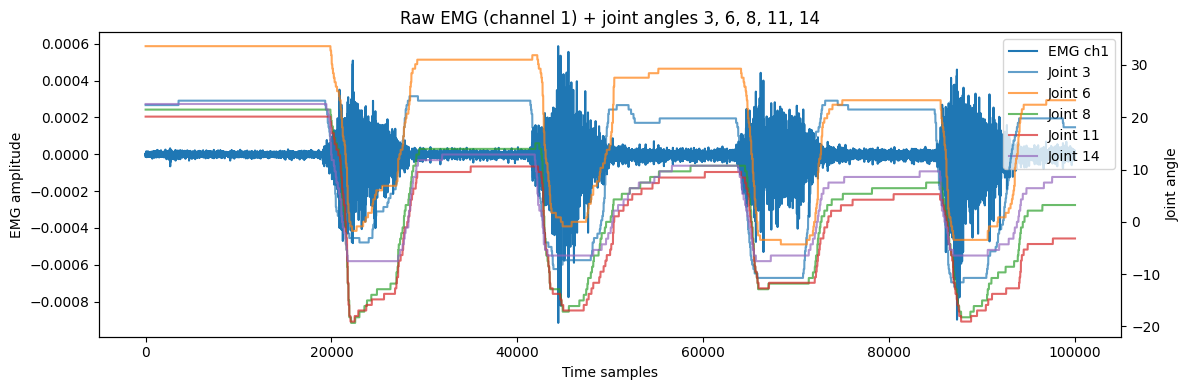

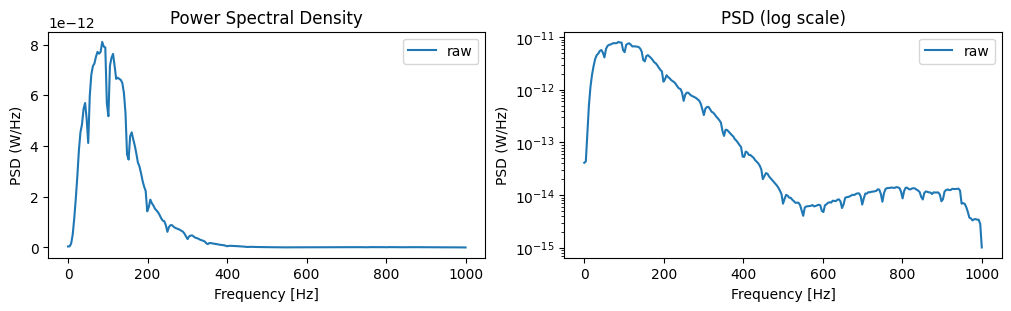

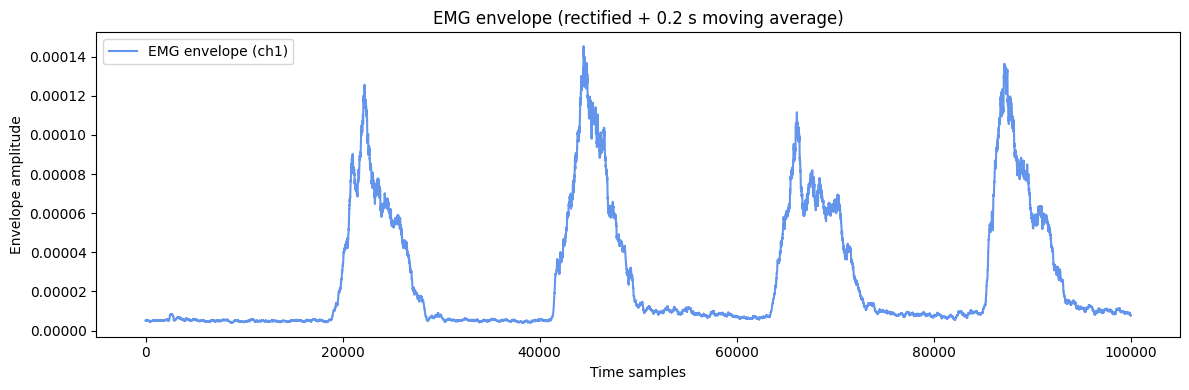

In [ ]:
# ============================================================
# Cell 0: Imports, data loading and basic visualizations
# ============================================================

# Some code structure and comments were refactored with the assistance of OpenAI ChatGPT under the author's supervision.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import welch

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)



# --------- Load data ---------
data = loadmat("S1_E1_A1.mat")
emg_data = np.asarray(data["emg"])    # (T, 16)
glove    = np.asarray(data["glove"])  # (T, 18)

fs = 2000  # sampling frequency

# Use joint angles 3, 6, 8, 11, 14 (1-based → 0-based)
joint_ids  = [3, 6, 8, 11, 14]
joint_cols = [j - 1 for j in joint_ids]
glove_sel  = glove[:, joint_cols]

print("Raw EMG shape:", emg_data.shape)
print("Selected glove shape:", glove_sel.shape)

# --------- Quick time-series plot (EMG ch1 + 5 joints) ---------
n_show = min(fs * 50, emg_data.shape[0])

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(emg_data[:n_show, 0], label="EMG ch1", color="tab:blue")
ax1.set_xlabel("Time samples")
ax1.set_ylabel("EMG amplitude")
ax1.grid(False)

ax2 = ax1.twinx()
for idx, jid in enumerate(joint_ids):
    ax2.plot(glove_sel[:n_show, idx], label=f"Joint {jid}", alpha=0.7)
ax2.set_ylabel("Joint angle")
ax2.grid(False)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right")

plt.title("Raw EMG (channel 1) + joint angles 3, 6, 8, 11, 14")
plt.tight_layout()
plt.show()

# --------- PSD of EMG ch1 ---------
freqs_pre, Pxx_pre = welch(emg_data[:, 0], fs=fs, nperseg=512)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("PSD (W/Hz)")
ax[0].set_title("Power Spectral Density")
ax[0].legend()

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("PSD (W/Hz)")
ax[1].set_title("PSD (log scale)")
ax[1].legend()

plt.show()

# --------- EMG envelope (rectified + moving average) ---------
mov_mean_size    = int(0.2 * fs)  # 0.2 s
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

emg_rect      = np.abs(emg_data)
EMG_envelopes = convolve1d(emg_rect, weights=mov_mean_weights, axis=0)

n_show = min(fs * 50, EMG_envelopes.shape[0])

plt.figure(figsize=(12, 4))
plt.plot(EMG_envelopes[:n_show, 0],
         label="EMG envelope (ch1)", color="cornflowerblue")
plt.title("EMG envelope (rectified + 0.2 s moving average)")
plt.xlabel("Time samples")
plt.ylabel("Envelope amplitude")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ============================================================
# Cell 1: Basic preprocessing and train/val/test split (time series)
# ============================================================

# Convert EMG data to float and remove channel-wise mean
emg_data = emg_data.astype(np.float64)
emg_data = emg_data - np.mean(emg_data, axis=0, keepdims=True)

N = emg_data.shape[0]
train_ratio = 0.6
val_ratio   = 0.2

idx_train_end = int(train_ratio * N)
idx_val_end   = int((train_ratio + val_ratio) * N)

# Time-contiguous splits (important for time-series)
EMG_train_samples = emg_data[:idx_train_end, :]
EMG_val_samples   = emg_data[idx_train_end:idx_val_end, :]
EMG_test_samples  = emg_data[idx_val_end:, :]

Y_train_samples = glove_sel[:idx_train_end, :]
Y_val_samples   = glove_sel[idx_train_end:idx_val_end, :]
Y_test_samples  = glove_sel[idx_val_end:, :]

print("Raw EMG time-series split:")
print("  Train:", EMG_train_samples.shape, Y_train_samples.shape)
print("  Val:  ", EMG_val_samples.shape,   Y_val_samples.shape)
print("  Test: ", EMG_test_samples.shape,  Y_test_samples.shape)


Raw EMG time-series split:
  Train: (1375515, 16) (1375515, 5)
  Val:   (458505, 16) (458505, 5)
  Test:  (458506, 16) (458506, 5)


In [5]:
# ============================================================
# Cell 2: Sliding-window helper
# ============================================================

def make_windows(emg_seg, glove_seg, win_len, step):
    """
    Create sliding windows from time-series data.

    Parameters
    ----------
    emg_seg   : (T, n_channels)
    glove_seg : (T, n_joints)
    win_len   : window length (samples)
    step      : step size (samples)

    Returns
    -------
    emg_w    : (n_windows, win_len, n_channels)
    glove_w  : (n_windows, win_len, n_joints)
    """
    T = emg_seg.shape[0]
    start_indices = np.arange(0, T - win_len + 1, step)
    n_windows = len(start_indices)

    emg_w   = np.zeros((n_windows, win_len, emg_seg.shape[1]))
    glove_w = np.zeros((n_windows, win_len, glove_seg.shape[1]))

    for i, s in enumerate(start_indices):
        e = s + win_len
        emg_w[i]   = emg_seg[s:e]
        glove_w[i] = glove_seg[s:e]

    return emg_w, glove_w

print("make_windows() defined.")


make_windows() defined.


In [6]:
# ============================================================
# Cell 3: Simple feature extractor (mean / variance / max)
# ============================================================

def extract_features_simple(EMG_windows, Label_windows):
    """
    Simple baseline features (per window, per channel):
      - mean
      - variance
      - max

    Label:
      - joint angles at the center of the window
    """
    x = EMG_windows  # (n_win, win_len, n_ch)

    mean_ = np.mean(x, axis=1)
    var_  = np.var(x, axis=1)
    max_  = np.max(x, axis=1)

    X = np.concatenate([mean_, var_, max_], axis=1)

    center_idx = Label_windows.shape[1] // 2
    y = Label_windows[:, center_idx, :]

    return X, y

print("extract_features_simple() defined.")


extract_features_simple() defined.


In [7]:
# ============================================================
# Cell 4: Window length + RF hyperparameter search (SIMPLE features)
# ============================================================

# Candidate window lengths (seconds)
win_len_sec_candidates = [0.10, 0.15, 0.20]  # 100 / 150 / 200 ms

# Random Forest hyperparameter grid
rf_param_grid = {
    "n_estimators":     [100, 200],
    "max_depth":        [10, None],
    "min_samples_leaf": [1, 5],
    "max_features":     ["sqrt"],
}

# Build full parameter list
rf_param_list = []
for ne, md, msl, mf in itertools.product(
    rf_param_grid["n_estimators"],
    rf_param_grid["max_depth"],
    rf_param_grid["min_samples_leaf"],
    rf_param_grid["max_features"],
):
    rf_param_list.append({
        "n_estimators": ne,
        "max_depth": md,
        "min_samples_leaf": msl,
        "max_features": mf,
        "random_state": 0,
        "n_jobs": -1,
    })

search_rows_simple = []
best_simple_cfg = {
    "mean_r2": -np.inf,
    "win_len_sec": None,
    "rf_params": None,
    "r2_per_joint": None,
}

for wl in win_len_sec_candidates:
    win_len = int(wl * fs)
    step    = int((wl / 4.0) * fs)   # 75% overlap

    print(f"\n=== SIMPLE features – window length: {wl*1000:.0f} ms ===")

    EMG_win_train_w, Label_win_train_w = make_windows(
        EMG_train_samples, Y_train_samples, win_len, step
    )
    EMG_win_val_w, Label_win_val_w = make_windows(
        EMG_val_samples, Y_val_samples, win_len, step
    )

    X_train_w, y_train_w = extract_features_simple(EMG_win_train_w, Label_win_train_w)
    X_val_w,   y_val_w   = extract_features_simple(EMG_win_val_w,   Label_win_val_w)

    scaler_w = StandardScaler()
    X_train_w_norm = scaler_w.fit_transform(X_train_w)
    X_val_w_norm   = scaler_w.transform(X_val_w)

    for rf_params in rf_param_list:
        rf = RandomForestRegressor(**rf_params)
        rf.fit(X_train_w_norm, y_train_w)

        y_val_pred = rf.predict(X_val_w_norm)
        mean_r2    = r2_score(y_val_w, y_val_pred, multioutput="uniform_average")
        r2_per     = r2_score(y_val_w, y_val_pred, multioutput="raw_values")

        search_rows_simple.append({
            "win_len_ms": wl * 1000,
            "n_estimators": rf_params["n_estimators"],
            "max_depth": rf_params["max_depth"],
            "min_samples_leaf": rf_params["min_samples_leaf"],
            "max_features": rf_params["max_features"],
            "val_mean_r2": mean_r2,
            "val_r2_j3":  r2_per[0],
            "val_r2_j6":  r2_per[1],
            "val_r2_j8":  r2_per[2],
            "val_r2_j11": r2_per[3],
            "val_r2_j14": r2_per[4],
        })

        if mean_r2 > best_simple_cfg["mean_r2"]:
            best_simple_cfg["mean_r2"]      = mean_r2
            best_simple_cfg["win_len_sec"]  = wl
            best_simple_cfg["rf_params"]    = rf_params
            best_simple_cfg["r2_per_joint"] = r2_per

df_simple_search = pd.DataFrame(search_rows_simple).sort_values(
    "val_mean_r2", ascending=False
).reset_index(drop=True)

print("\n=== SIMPLE features: validation search summary (top 10) ===")
print(df_simple_search.head(10))

print("\n>>> Selected SIMPLE configuration (best mean Val R²):")
print(f"  Window length: {best_simple_cfg['win_len_sec']*1000:.0f} ms")
print(f"  RF params:     {best_simple_cfg['rf_params']}")
print(f"  Mean Val R²:   {best_simple_cfg['mean_r2']:.4f}")
print("  Val R² per joint:", np.round(best_simple_cfg["r2_per_joint"], 4))



=== SIMPLE features – window length: 100 ms ===

=== SIMPLE features – window length: 150 ms ===

=== SIMPLE features – window length: 200 ms ===

=== SIMPLE features: validation search summary (top 10) ===
   win_len_ms  n_estimators  max_depth  min_samples_leaf max_features  \
0       150.0           200        NaN                 1         sqrt   
1       150.0           100       10.0                 1         sqrt   
2       200.0           200       10.0                 1         sqrt   
3       200.0           100        NaN                 1         sqrt   
4       150.0           100        NaN                 1         sqrt   
5       200.0           200        NaN                 1         sqrt   
6       150.0           200       10.0                 1         sqrt   
7       200.0           100       10.0                 1         sqrt   
8       200.0           100       10.0                 5         sqrt   
9       200.0           200       10.0                 5      

In [8]:
# ============================================================
# Cell 5: Final windowing + SIMPLE features + normalization
# ============================================================

best_win_len_sec = best_simple_cfg["win_len_sec"]
win_len_sec = best_win_len_sec
step_sec    = best_win_len_sec / 4.0

win_len = int(win_len_sec * fs)
step    = int(step_sec * fs)

print(
    f"\nFinal sliding-window configuration (SIMPLE): "
    f"win_len = {win_len} samples ({win_len_sec*1000:.0f} ms), "
    f"step = {step} samples ({step_sec*1000:.0f} ms)"
)

# --- Window all sets ---
EMG_win_train, Label_win_train = make_windows(
    EMG_train_samples, Y_train_samples, win_len, step
)
EMG_win_val, Label_win_val = make_windows(
    EMG_val_samples, Y_val_samples, win_len, step
)
EMG_win_test, Label_win_test = make_windows(
    EMG_test_samples, Y_test_samples, win_len, step
)

print("\nWindowed data shapes (final config):")
print("  EMG_win_train:", EMG_win_train.shape,
      " Label_win_train:", Label_win_train.shape)
print("  EMG_win_val:  ", EMG_win_val.shape,
      " Label_win_val:  ", Label_win_val.shape)
print("  EMG_win_test: ", EMG_win_test.shape,
      " Label_win_test:", Label_win_test.shape)

# --- SIMPLE features ---
X_train, y_train = extract_features_simple(EMG_win_train, Label_win_train)
X_val,   y_val   = extract_features_simple(EMG_win_val,   Label_win_val)
X_test,  y_test  = extract_features_simple(EMG_win_test,  Label_win_test)

print("\nFeature matrix shapes (SIMPLE):")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)

# --- Normalization ---
scaler_simple = StandardScaler()
X_train_norm = scaler_simple.fit_transform(X_train)
X_val_norm   = scaler_simple.transform(X_val)
X_test_norm  = scaler_simple.transform(X_test)

print("\nAfter normalization (train statistics, first 5 dims):")
print("  mean ≈", np.round(X_train_norm.mean(axis=0)[:5], 4))
print("  std  ≈", np.round(X_train_norm.std(axis=0)[:5],  4))



Final sliding-window configuration (SIMPLE): win_len = 300 samples (150 ms), step = 75 samples (38 ms)

Windowed data shapes (final config):
  EMG_win_train: (18337, 300, 16)  Label_win_train: (18337, 300, 5)
  EMG_win_val:   (6110, 300, 16)  Label_win_val:   (6110, 300, 5)
  EMG_win_test:  (6110, 300, 16)  Label_win_test: (6110, 300, 5)

Feature matrix shapes (SIMPLE):
  X_train: (18337, 48)  y_train: (18337, 5)
  X_val:   (6110, 48)  y_val:   (6110, 5)
  X_test:  (6110, 48)  y_test:  (6110, 5)

After normalization (train statistics, first 5 dims):
  mean ≈ [-0.  0.  0. -0. -0.]
  std  ≈ [1. 1. 1. 1. 1.]


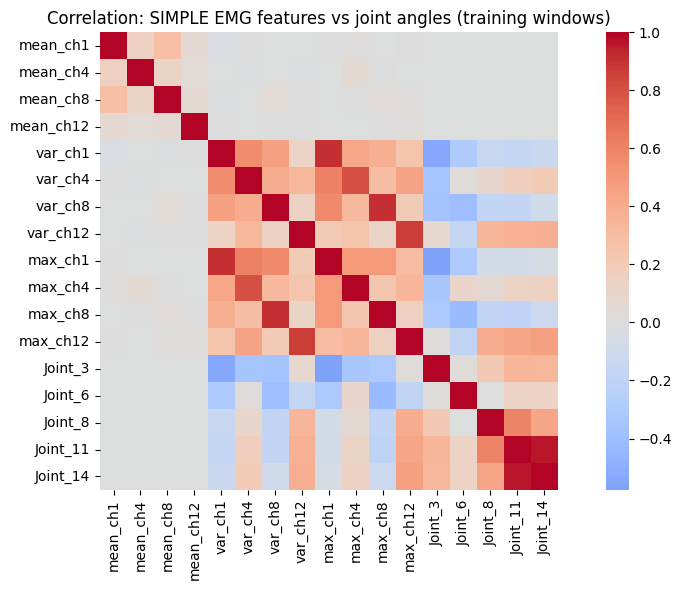

In [9]:
# ============================================================
# Cell 6: Correlation between SIMPLE features and joint angles
# ============================================================

n_ch = EMG_win_train.shape[2]
feat_types = ["mean", "var", "max"]
feat_names = [
    f"{ft}_ch{c+1}"
    for ft in feat_types
    for c in range(n_ch)
]

# example channels for visualization
keep_ch = [0, 3, 7, 11]
idx_keep = []
for ft_idx, _ in enumerate(feat_types):
    idx_keep += [ft_idx * n_ch + c for c in keep_ch]

feat_cols_kept = [feat_names[i] for i in idx_keep]
joint_cols_names = [f"Joint_{jid}" for jid in joint_ids]

corr_input = np.concatenate(
    [X_train_norm[:, idx_keep], y_train],
    axis=1
)

df_corr = pd.DataFrame(
    corr_input,
    columns=feat_cols_kept + joint_cols_names
)

corr_mat = df_corr.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_mat,
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation: SIMPLE EMG features vs joint angles (training windows)")
plt.tight_layout()
plt.show()


In [10]:
# ============================================================
# Cell 7: Multi-output RF using SIMPLE features (final model)
# ============================================================

best_rf_params_simple = best_simple_cfg["rf_params"]

# Combine train + val for final training
X_trval_norm = np.concatenate([X_train_norm, X_val_norm], axis=0)
y_trval      = np.concatenate([y_train,      y_val],      axis=0)

print("X_trval_norm:", X_trval_norm.shape, " y_trval:", y_trval.shape)

rf_multi_simple = RandomForestRegressor(**best_rf_params_simple)
rf_multi_simple.fit(X_trval_norm, y_trval)

# --- Evaluate on test set ---
y_test_pred_simple = rf_multi_simple.predict(X_test_norm)

r2_per_joint = r2_score(y_test, y_test_pred_simple, multioutput="raw_values")
mse_per_joint = mean_squared_error(y_test, y_test_pred_simple, multioutput="raw_values")
mae_per_joint = mean_absolute_error(y_test, y_test_pred_simple, multioutput="raw_values")

mean_r2  = r2_score(y_test, y_test_pred_simple, multioutput="uniform_average")
mean_mse = float(np.mean(mse_per_joint))
mean_mae = float(np.mean(mae_per_joint))

print("\n=== Multi-output RF (SIMPLE) - Test performance per joint ===")
for jid, r2j, msej, maej in zip(joint_ids, r2_per_joint, mse_per_joint, mae_per_joint):
    print(f"Joint {jid:2d}: R²={r2j:7.4f}, MSE={msej:8.2f}, MAE={maej:6.2f}")

print("\n=== Multi-output RF (SIMPLE) - Test performance (mean) ===")
print(f"Mean R² : {mean_r2:.4f}")
print(f"Mean MSE: {mean_mse:.2f}")
print(f"Mean MAE: {mean_mae:.2f}")


X_trval_norm: (24447, 48)  y_trval: (24447, 5)

=== Multi-output RF (SIMPLE) - Test performance per joint ===
Joint  3: R²=-0.3916, MSE=  436.83, MAE= 14.24
Joint  6: R²= 0.0175, MSE= 1003.43, MAE= 20.02
Joint  8: R²= 0.0867, MSE= 1559.06, MAE= 24.91
Joint 11: R²= 0.5920, MSE=  537.38, MAE= 15.22
Joint 14: R²= 0.6205, MSE=  669.96, MAE= 18.81

=== Multi-output RF (SIMPLE) - Test performance (mean) ===
Mean R² : 0.1850
Mean MSE: 841.33
Mean MAE: 18.64


In [ ]:
# ============================================================
# Cell 7b: One RF per joint (SIMPLE features)
# ============================================================

rf_per_joint = {}
r2_per_joint_single  = []
mse_per_joint_single = []
mae_per_joint_single = []

for j_idx, jid in enumerate(joint_ids):
    rf_j = RandomForestRegressor(**best_rf_params_simple)
    rf_j.fit(X_trval_norm, y_trval[:, j_idx])

    y_test_pred_j = rf_j.predict(X_test_norm)

    r2_j  = r2_score(y_test[:, j_idx], y_test_pred_j)
    mse_j = mean_squared_error(y_test[:, j_idx], y_test_pred_j)
    mae_j = mean_absolute_error(y_test[:, j_idx], y_test_pred_j)

    rf_per_joint[jid] = rf_j
    r2_per_joint_single.append(r2_j)
    mse_per_joint_single.append(mse_j)
    mae_per_joint_single.append(mae_j)

df_single_vs_multi = pd.DataFrame({
    "joint_id": joint_ids,
    "R2_multi":  r2_per_joint,          # Cell 7 multi-output RF
    "R2_single": r2_per_joint_single,
    "MAE_multi": mae_per_joint,
    "MAE_single": mae_per_joint_single,
})

print("=== One RF per joint (SIMPLE) – Test performance ===")
print(df_single_vs_multi)

mean_r2_single = np.mean(r2_per_joint_single)
mean_mae_single = np.mean(mae_per_joint_single)
print("\nMean R² (single-joint RFs):",  mean_r2_single)
print("Mean MAE (single-joint RFs):", mean_mae_single)
print("Mean R² (multi-output RF):  ", mean_r2)
print("Mean MAE (multi-output RF): ", mean_mae)


=== One RF per joint (SIMPLE) – Test performance ===
   joint_id  R2_multi  R2_single  MAE_multi  MAE_single
0         3 -0.391579  -0.522014  14.242776   14.642109
1         6  0.017469  -0.017087  20.023020   20.327412
2         8  0.086704   0.047834  24.910331   25.519864
3        11  0.592000   0.579315  15.215131   15.384913
4        14  0.620485   0.648397  18.811496   18.277414

Mean R² (single-joint RFs): 0.14728891587504517
Mean MAE (single-joint RFs): 18.83034235205759
Mean R² (multi-output RF):   0.1850158484902415
Mean MAE (multi-output RF):  18.640550856464436



=== Stability across joints (TEST, SIMPLE) ===
   joint_id        R2        MAE
0         3 -0.391579  14.242776
1         6  0.017469  20.023020
2         8  0.086704  24.910331
3        11  0.592000  15.215131
4        14  0.620485  18.811496


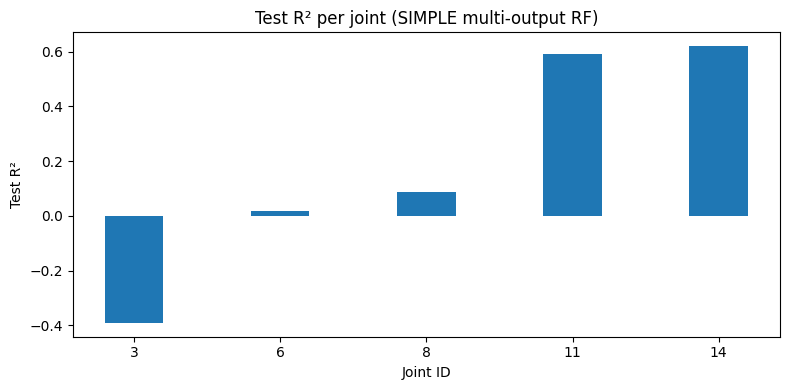

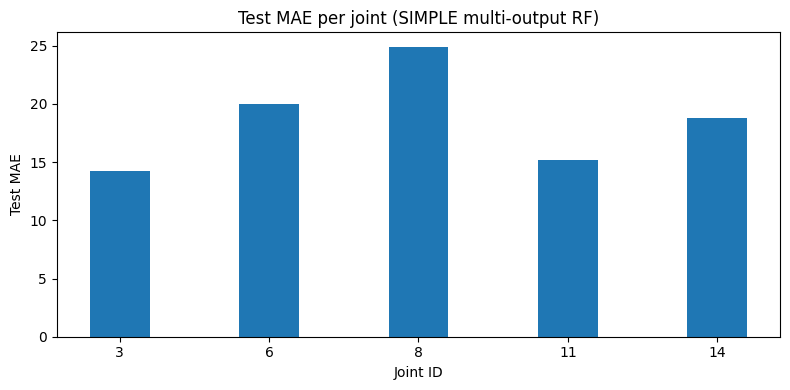

In [12]:
# ============================================================
# Cell 8: Stability across joints (R² / MAE bar plots)
# ============================================================

df_joints = pd.DataFrame({
    "joint_id": joint_ids,
    "R2":  r2_per_joint,
    "MAE": mae_per_joint,
})

print("\n=== Stability across joints (TEST, SIMPLE) ===")
print(df_joints)

x = np.arange(len(joint_ids))
bar_w = 0.4

plt.figure(figsize=(8, 4))
plt.bar(x, r2_per_joint, width=bar_w)
plt.xticks(x, [str(j) for j in joint_ids])
plt.xlabel("Joint ID")
plt.ylabel("Test R²")
plt.title("Test R² per joint (SIMPLE multi-output RF)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(x, mae_per_joint, width=bar_w)
plt.xticks(x, [str(j) for j in joint_ids])
plt.xlabel("Joint ID")
plt.ylabel("Test MAE")
plt.title("Test MAE per joint (SIMPLE multi-output RF)")
plt.tight_layout()
plt.show()


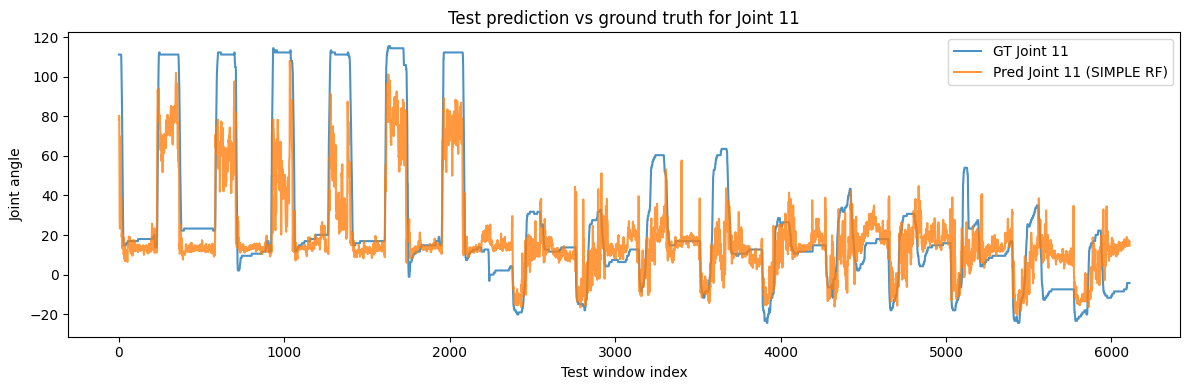

In [13]:
# ============================================================
# Cell 9: Example prediction vs ground truth (one joint)
# ============================================================

joint_to_plot = 11
j_idx = joint_ids.index(joint_to_plot)

plt.figure(figsize=(12, 4))
plt.plot(y_test[:, j_idx],        label=f"GT Joint {joint_to_plot}", alpha=0.8)
plt.plot(y_test_pred_simple[:, j_idx],
         label=f"Pred Joint {joint_to_plot} (SIMPLE RF)", alpha=0.8)

plt.title(f"Test prediction vs ground truth for Joint {joint_to_plot}")
plt.xlabel("Test window index")
plt.ylabel("Joint angle")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# Appendix A0: Advanced feature extractor (td6fd2-style)
# ============================================================

USE_ZC_SSC = True
# ZC might have some problems: threshold=0

def extract_features_advanced(
    EMG_windows, Label_windows, fs,
    use_zc_ssc=USE_ZC_SSC,
    zc_ssc_thresh=None,
    eps=1e-12,
):
    """
    Advanced EMG features for each window & channel.

    Time-domain:
      MAV, RMS, WL, LOGVAR, (optional) ZC, SSC

    Frequency-domain:
      MNF, MDF

    Returns X, y (labels at center frame).
    """
    x = EMG_windows
    n_win, win_len, n_ch = x.shape

    # --- TD basics ---
    mav = np.mean(np.abs(x), axis=1)
    rms = np.sqrt(np.mean(x ** 2, axis=1) + eps)

    diff = np.diff(x, axis=1)
    wl   = np.sum(np.abs(diff), axis=1)

    var_   = np.var(x, axis=1)
    logvar = np.log(var_ + eps)

    feats = [mav, rms, wl, logvar]

    # --- ZC / SSC ---
    if use_zc_ssc:
        if zc_ssc_thresh is None:
            zc_ssc_thresh = 0.01 * np.std(x)

        x1 = x[:, :-1, :]
        x2 = x[:, 1:, :]
        zc = np.sum(
            (x1 * x2 < 0) &
            ((np.abs(x1) > zc_ssc_thresh) |
             (np.abs(x2) > zc_ssc_thresh)),
            axis=1
        )

        d1  = x[:, 1:-1, :] - x[:, :-2, :]
        d2  = x[:, 1:-1, :] - x[:, 2:, :]
        ssc = np.sum(
            (d1 * d2 < 0) &
            ((np.abs(d1) > zc_ssc_thresh) |
             (np.abs(d2) > zc_ssc_thresh)),
            axis=1
        )

        feats.extend([zc, ssc])

    # --- Frequency domain (MNF / MDF) ---
    Xf  = np.fft.rfft(x, axis=1)
    psd = np.abs(Xf) ** 2
    freqs = np.fft.rfftfreq(win_len, d=1.0 / fs)

    mnf = np.sum(psd * freqs[None, :, None], axis=1) / (np.sum(psd, axis=1) + eps)

    cumsum_psd = np.cumsum(psd, axis=1)
    half_power = np.sum(psd, axis=1) / 2.0
    idx_mdf = (cumsum_psd >= half_power[:, None, :]).argmax(axis=1)
    mdf = freqs[idx_mdf]

    feats.extend([mnf, mdf])

    X = np.concatenate(feats, axis=1)

    center_idx = Label_windows.shape[1] // 2
    y = Label_windows[:, center_idx, :]

    return X, y

print("extract_features_advanced() defined (USE_ZC_SSC =", USE_ZC_SSC, ")")


extract_features_advanced() defined (USE_ZC_SSC = True )


In [ ]:
# ============================================================
# Appendix A1: RF hyperparameter search (ADVANCED features)
# ============================================================

X_train_adv, y_train_adv = extract_features_advanced(
    EMG_win_train, Label_win_train, fs
)
X_val_adv,   y_val_adv   = extract_features_advanced(
    EMG_win_val,   Label_win_val,   fs
)
X_test_adv,  y_test_adv  = extract_features_advanced(
    EMG_win_test,  Label_win_test,  fs
)

print("Advanced feature shapes:")
print("  X_train_adv:", X_train_adv.shape, " y_train_adv:", y_train_adv.shape)
print("  X_val_adv:  ", X_val_adv.shape,   " y_val_adv:  ", y_val_adv.shape)
print("  X_test_adv: ", X_test_adv.shape,  " y_test_adv: ", y_test_adv.shape)

scaler_adv = StandardScaler()
X_train_adv_norm = scaler_adv.fit_transform(X_train_adv)
X_val_adv_norm   = scaler_adv.transform(X_val_adv)
X_test_adv_norm  = scaler_adv.transform(X_test_adv)

# RF grid
rf_param_grid_adv = rf_param_grid  # reuse
rf_param_list_adv = rf_param_list  # reuse

best_adv_cfg = {
    "mean_r2": -np.inf,
    "rf_params": None,
    "r2_per_joint": None,
}

rows_adv_search = []

for rf_params in rf_param_list_adv:
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_adv_norm, y_train_adv)

    y_val_pred_adv = rf.predict(X_val_adv_norm)

    mean_r2_adv = r2_score(
        y_val_adv, y_val_pred_adv, multioutput="uniform_average"
    )
    r2_per_adv  = r2_score(
        y_val_adv, y_val_pred_adv, multioutput="raw_values"
    )

    rows_adv_search.append({
        "n_estimators": rf_params["n_estimators"],
        "max_depth": rf_params["max_depth"],
        "min_samples_leaf": rf_params["min_samples_leaf"],
        "max_features": rf_params["max_features"],
        "val_mean_r2": mean_r2_adv,
        "val_r2_j3":  r2_per_adv[0],
        "val_r2_j6":  r2_per_adv[1],
        "val_r2_j8":  r2_per_adv[2],
        "val_r2_j11": r2_per_adv[3],
        "val_r2_j14": r2_per_adv[4],
    })

    if mean_r2_adv > best_adv_cfg["mean_r2"]:
        best_adv_cfg["mean_r2"]      = mean_r2_adv
        best_adv_cfg["rf_params"]    = rf_params
        best_adv_cfg["r2_per_joint"] = r2_per_adv

df_adv_search = pd.DataFrame(rows_adv_search).sort_values(
    "val_mean_r2", ascending=False
).reset_index(drop=True)

print("\n=== ADVANCED features: validation search summary (top 10) ===")
print(df_adv_search.head(10))

print("\n>>> Selected ADVANCED configuration:")
print("  RF params:", best_adv_cfg["rf_params"])
print("  Mean Val R²:", best_adv_cfg["mean_r2"])
print("  Val R² per joint:", np.round(best_adv_cfg["r2_per_joint"], 4))


Advanced feature shapes:
  X_train_adv: (18337, 128)  y_train_adv: (18337, 5)
  X_val_adv:   (6110, 128)  y_val_adv:   (6110, 5)
  X_test_adv:  (6110, 128)  y_test_adv:  (6110, 5)

=== ADVANCED features: validation search summary (top 10) ===
   n_estimators  max_depth  min_samples_leaf max_features  val_mean_r2  \
0           200        NaN                 5         sqrt    -0.217014   
1           100        NaN                 5         sqrt    -0.218904   
2           200       10.0                 1         sqrt    -0.225011   
3           100       10.0                 1         sqrt    -0.231357   
4           100        NaN                 1         sqrt    -0.239252   
5           200       10.0                 5         sqrt    -0.239459   
6           200        NaN                 1         sqrt    -0.239762   
7           100       10.0                 5         sqrt    -0.259701   

   val_r2_j3  val_r2_j6  val_r2_j8  val_r2_j11  val_r2_j14  
0  -1.075985  -0.380939  -0.0

In [16]:
# ============================================================
# Appendix A2: Final ADVANCED RF model + comparison
# ============================================================

best_rf_params_adv = best_adv_cfg["rf_params"]

# Train on train+val
X_trval_adv_norm = np.concatenate([X_train_adv_norm, X_val_adv_norm], axis=0)
y_trval_adv      = np.concatenate([y_train_adv,      y_val_adv],      axis=0)

rf_adv = RandomForestRegressor(**best_rf_params_adv)
rf_adv.fit(X_trval_adv_norm, y_trval_adv)

# Test evaluation
y_test_pred_adv = rf_adv.predict(X_test_adv_norm)

r2_adv_per_joint = r2_score(y_test_adv, y_test_pred_adv, multioutput="raw_values")
mse_adv_per_joint = mean_squared_error(y_test_adv, y_test_pred_adv, multioutput="raw_values")
mae_adv_per_joint = mean_absolute_error(y_test_adv, y_test_pred_adv, multioutput="raw_values")

mean_r2_adv  = r2_score(y_test_adv, y_test_pred_adv, multioutput="uniform_average")
mean_mse_adv = float(np.mean(mse_adv_per_joint))
mean_mae_adv = float(np.mean(mae_adv_per_joint))

print("\n=== Advanced RF - Test performance per joint ===")
for jid, r2j, msej, maej in zip(joint_ids, r2_adv_per_joint, mse_adv_per_joint, mae_adv_per_joint):
    print(f"Joint {jid:2d}: R²={r2j:7.4f}, MSE={msej:8.2f}, MAE={maej:6.2f}")

print("\n=== Advanced RF - Test performance (mean) ===")
print(f"Mean R² : {mean_r2_adv:.4f}")
print(f"Mean MSE: {mean_mse_adv:.2f}")
print(f"Mean MAE: {mean_mae_adv:.2f}")

# --- Simple vs Advanced summary table ---
df_feat_cmp = pd.DataFrame([
    {
        "feature_set": "simple (mean/var/max)",
        "test_mean_r2": mean_r2,
        "test_mean_mse": mean_mse,
        "test_mean_mae": mean_mae,
    },
    {
        "feature_set": f"advanced (td6fd2, USE_ZC_SSC={USE_ZC_SSC})",
        "test_mean_r2": mean_r2_adv,
        "test_mean_mse": mean_mse_adv,
        "test_mean_mae": mean_mae_adv,
    },
])

print("\n=== Simple vs Advanced (TEST) ===")
print(df_feat_cmp)



=== Advanced RF - Test performance per joint ===
Joint  3: R²=-0.4540, MSE=  456.43, MAE= 14.24
Joint  6: R²=-0.0415, MSE= 1063.60, MAE= 20.55
Joint  8: R²= 0.0269, MSE= 1661.21, MAE= 25.54
Joint 11: R²= 0.5300, MSE=  619.11, MAE= 16.14
Joint 14: R²= 0.6011, MSE=  704.25, MAE= 18.55

=== Advanced RF - Test performance (mean) ===
Mean R² : 0.1325
Mean MSE: 900.92
Mean MAE: 19.00

=== Simple vs Advanced (TEST) ===
                          feature_set  test_mean_r2  test_mean_mse  \
0               simple (mean/var/max)      0.185016     841.331909   
1  advanced (td6fd2, USE_ZC_SSC=True)      0.132483     900.917839   

   test_mean_mae  
0      18.640551  
1      19.003500  


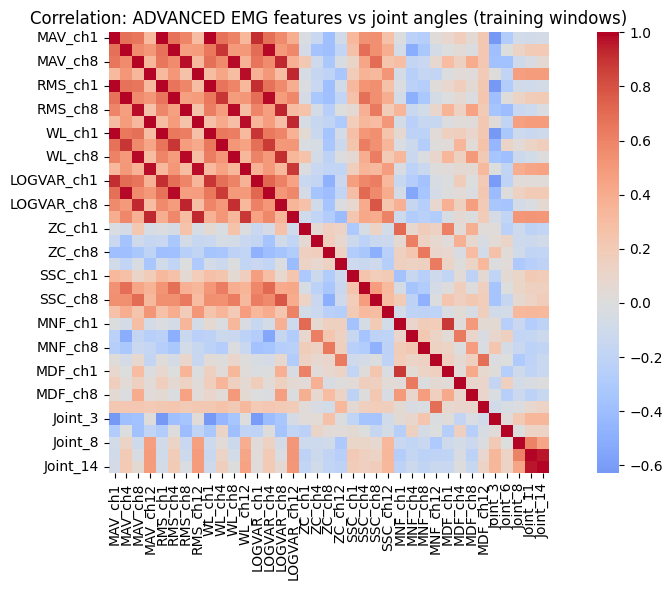

In [ ]:
# ============================================================
# Appendix A3: Correlation heatmap for ADVANCED features (optional)
# ============================================================

# Some channels
n_ch = EMG_win_train.shape[2]
# MAV/RMS/WL/LOGVAR/[ZC/SSC]/MNF/MDF
if USE_ZC_SSC:
    adv_feat_types = ["MAV", "RMS", "WL", "LOGVAR", "ZC", "SSC", "MNF", "MDF"]
else:
    adv_feat_types = ["MAV", "RMS", "WL", "LOGVAR", "MNF", "MDF"]

adv_feat_names = [
    f"{ft}_ch{c+1}"
    for ft in adv_feat_types
    for c in range(n_ch)
]

keep_ch = [0, 3, 7, 11]
idx_keep_adv = []
for ft_idx, _ in enumerate(adv_feat_types):
    idx_keep_adv += [ft_idx * n_ch + c for c in keep_ch]

adv_feat_cols_kept = [adv_feat_names[i] for i in idx_keep_adv]
joint_cols_names = [f"Joint_{jid}" for jid in joint_ids]

corr_input_adv = np.concatenate(
    [X_train_adv_norm[:, idx_keep_adv], y_train_adv],
    axis=1
)

df_corr_adv = pd.DataFrame(
    corr_input_adv,
    columns=adv_feat_cols_kept + joint_cols_names
)

corr_mat_adv = df_corr_adv.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_mat_adv,
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation: ADVANCED EMG features vs joint angles (training windows)")
plt.tight_layout()
plt.show()
